### Setup

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
import matplotlib as mpl

import json
from pandas.io.json import json_normalize
from scipy.stats import zscore
import scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
from adjustText import adjust_text

C:\Users\Pasha\miniconda3\envs\AIBS\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Pasha\miniconda3\envs\AIBS\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Pasha\miniconda3\envs\AIBS\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
#clean up default font to be more 'figure ready'
sns.set(font_scale=2)
sns.set_style('ticks')
new_rc_params = {'text.usetex': False, "svg.fonttype": 'none',
                 "axes.spines.right": False,
                 "axes.spines.top": False,
                 "axes.linewidth": 1.2,
                 "xtick.major.size": 6,
                 "xtick.major.width": 1.2,
                 "ytick.major.size": 6,
                 "ytick.major.width": 1.2,
                 "legend.frameon": False,
                 "legend.handletextpad": 0.1,
                 "font.family": 'arial', "font.size": 12,                 
}
mpl.rcParams.update(new_rc_params)

### load data

In [9]:
#laod diff data from figure 2 notebook
%store -r  cleaned_all_cfos_diff

#load ISH data, zscored
zscore_ISH = pd.read_csv(r'C:\Users\Pasha\2023_acs_code_data\ish_data_zscore.csv')

#load mesoscopic labels for gene data
hierarchy_meso_ids = pd.read_csv(r'C:\Users\Pasha\2023_acs_code_data\hierarchy_meso_ids.csv')

### merge datasets

In [10]:
#cFos
cfos_all = cleaned_all_cfos_diff
cfos_all = cfos_all.groupby(['Region_Name','abbreviation','Region_ID'])['psi-sal','psi-ket','ket-sal'].mean().reset_index()
cfos_all = cfos_all.merge(hierarchy_meso_ids, on='abbreviation')
cfos_all.rename(columns={'Region_Name_x':'Region_Name', 'Region_ID_x':'Region_ID'}, inplace=True)
cfos_all.drop(columns={'Region_ID_y','Region_Name_y'}, inplace=True)
cfos_x_genes = cfos_all.merge(zscore_ISH, on=['Region_ID','abbreviation','Brain Area'])
cfos_x_genes = cfos_x_genes.rename(columns={'Region_Name_x':'Region_Name'})
cfos_x_genes.drop(columns='Region_Name_y', inplace=True)

#matrices
cfos_matrix_psi = cfos_x_genes.pivot(values='psi-sal',index='gene_acronym', columns='Region_Name') #psilocybin
cfos_matrix_ket = cfos_x_genes.pivot(values='ket-sal',index='gene_acronym', columns='Region_Name') #ketamine
gene_matrix = cfos_x_genes.pivot(values='zscore',index='gene_acronym', columns='Region_Name')

In [4]:
#specify genes of interest
selected_receptors = ['Htr1a','Htr1b','Htr1d','Htr1f','Htr2a','Htr2b','Htr2c','Htr3a','Htr3b','Htr4','Htr5a','Htr5b','Htr6','Htr7','Slc6a4',
            'Pvalb', 'Sst', 'Vip', 'Sncg', 'Lamp5',
            'Gria2', 'Grik2','Grin2b',
            'Adra2a', 'Adra2b', 'Hrh1', 
            'Drd1', 'Drd2', 'Drd3', 'Oprm1']

zscore_select = zscore_ISH[zscore_ISH['gene_acronym'].isin(selected_receptors)]

### All gene x structure correlation

In [12]:
#this code will take a while to run....even if you modify to preallocate for speed/etc

#psilocybin correlation:
list_of_genes = cfos_x_genes.gene_acronym.unique()
psi_all_correlations = []

for gene in list_of_genes:
    cfos_x_genes_of_interest = cfos_x_genes[cfos_x_genes['gene_acronym'] == gene]
    correlation = cfos_x_genes_of_interest['zscore'].corr(cfos_x_genes_of_interest['psi-sal'])
    psi_all_correlations.append([gene, correlation])
    
psi_all_correlations = pd.DataFrame(psi_all_correlations, columns=['gene', 'correlation'])

#ketamine correlations
list_of_genes = cfos_x_genes.gene_acronym.unique()
ket_all_correlations = []

for gene in list_of_genes:
    cfos_x_genes_of_interest = cfos_x_genes[cfos_x_genes['gene_acronym'] == gene]
    correlation = cfos_x_genes_of_interest['zscore'].corr(cfos_x_genes_of_interest['ket-sal'])
    ket_all_correlations.append([gene, correlation])
    
ket_all_correlations = pd.DataFrame(ket_all_correlations, columns=['gene', 'correlation'])

### Brainwide Percentiles 

In [14]:
#psilocybin brain wide
psi_all_correlations['percentile'] = psi_all_correlations.correlation.rank(pct = True)
psi_all_correlations.sort_values(by=['percentile'], ascending=False, inplace=True)

#ketamine brain wide
ket_all_correlations['percentile'] = ket_all_correlations.correlation.rank(pct = True)
ket_all_correlations.sort_values(by=['percentile'], ascending=False, inplace=True)

In [15]:
#list genes of interest for correlation, use this to see relative gene correlation with psi/ket
geneList = ['Htr1a','Htr1b','Htr1d','Htr1f','Htr2a','Htr2b','Htr2c','Htr3a','Htr3b','Htr4','Htr5a','Htr5b','Htr6','Htr7','Slc6a4',
            'Pvalb', 'Sst', 'Vip', 'Sncg', 'Lamp5',
            'Gria2', 'Grin2b', 'Grin1', 'Grin2a', 'Gria1', 'Gria3', 'Gria4', 'Grik1',
            'Adra2a', 'Adra2b', 'Hrh1', 
            'Drd1', 'Drd2', 'Drd3', 'Oprm1']

genes_of_interest = ket_all_correlations[ket_all_correlations['gene'].isin(geneList)]

#### Fig 4B: Genes x all brain (psilocybin)

Text(0, 0.5, 'Number of genes')

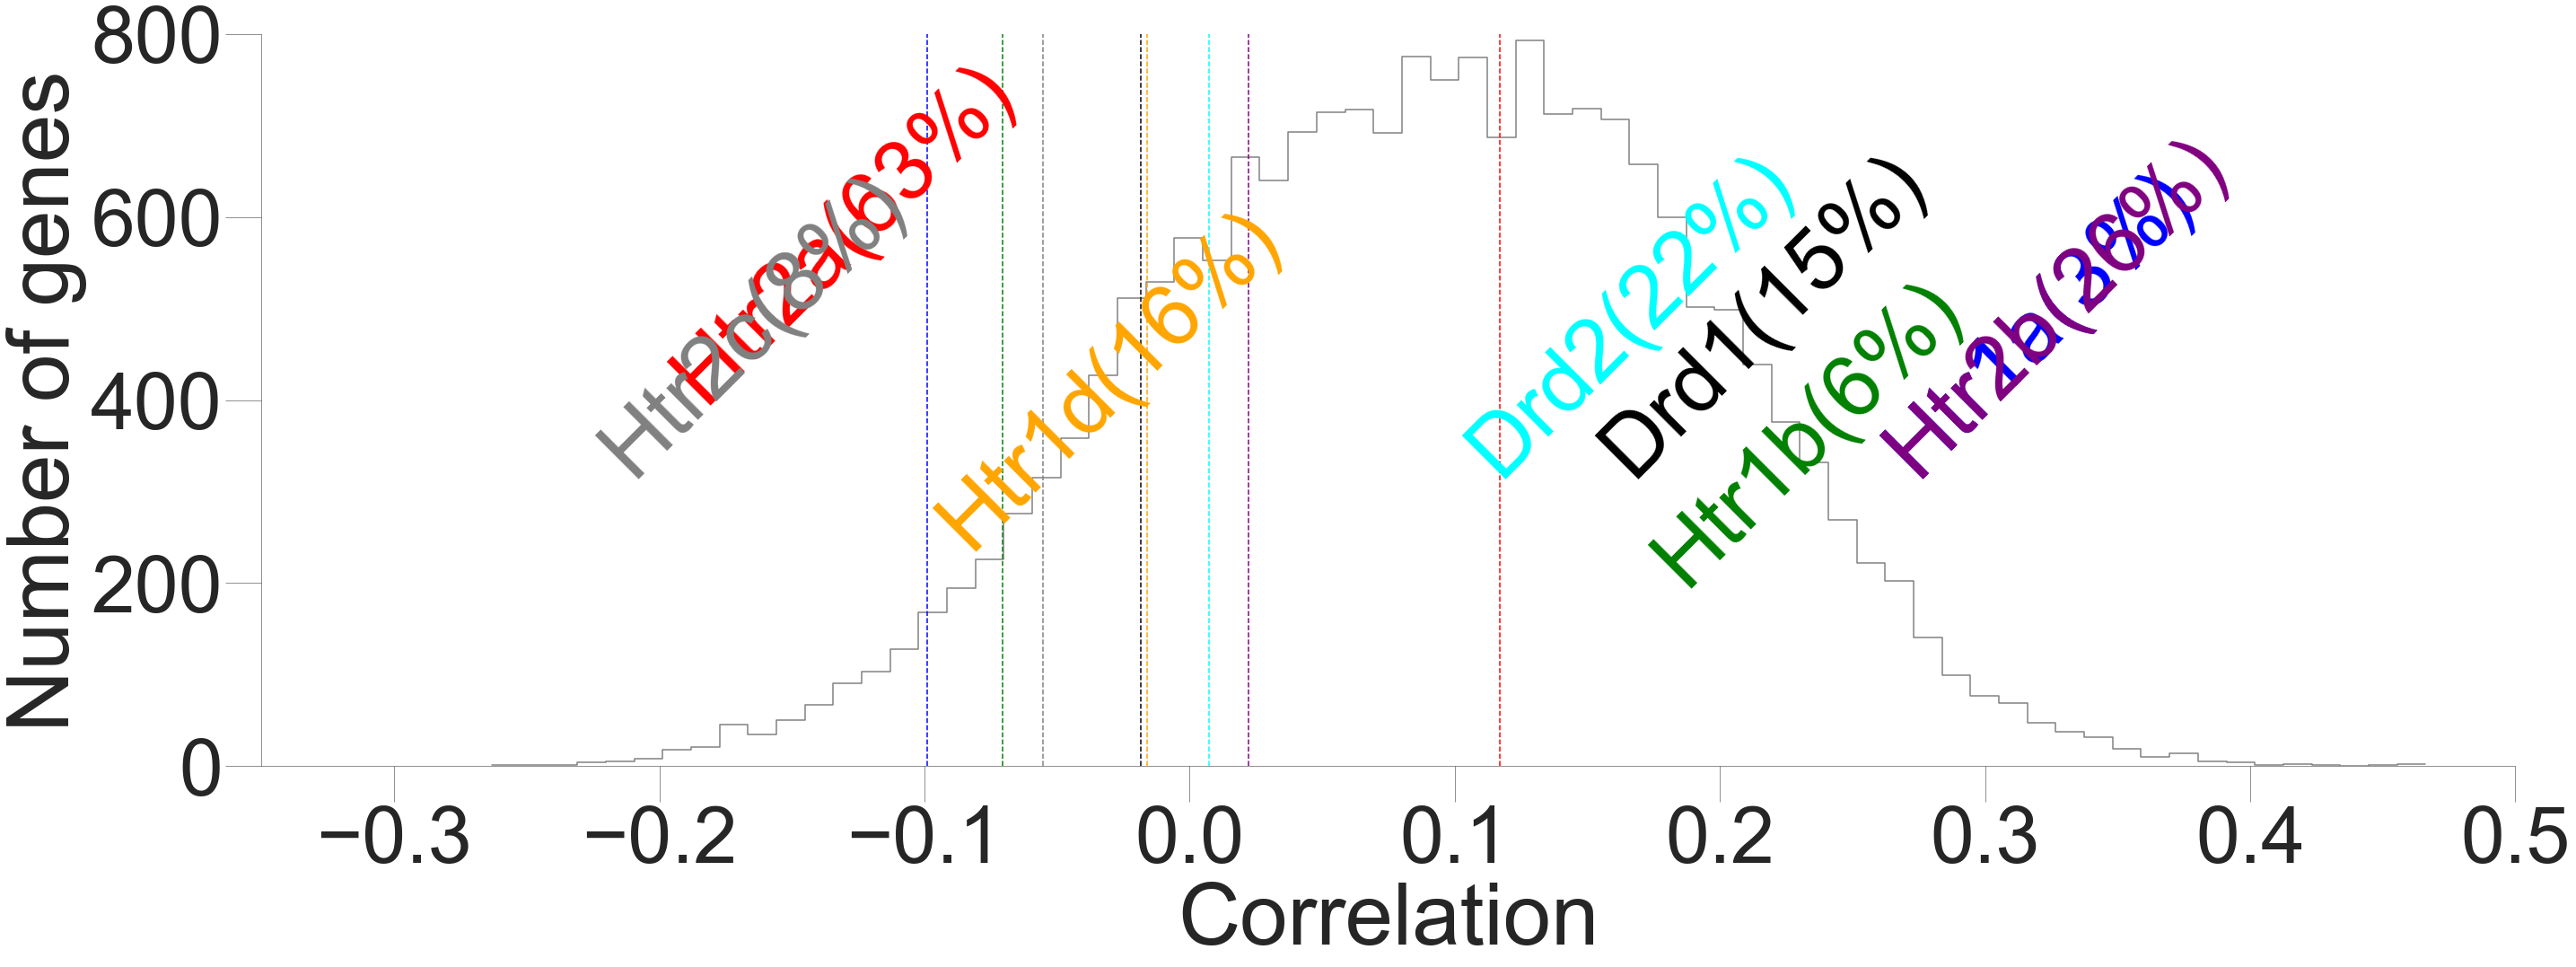

In [32]:
#plot main figure for all genes
plt.figure(figsize=(45,15))
sns.set(style="ticks", font_scale=8)

ax = sns.histplot(data=psi_all_correlations, x="correlation", element = 'step', fill=False, color='grey')
sns.despine()

trans = ax.get_xaxis_transform()

#htr1a
plt.axvline(x=-0.098825, color='blue', linestyle='--')
plt.text(0.257424, .4, 'Htr1a(3%)', transform=trans, color='blue', rotation=45)

#htr2a
plt.axvline(x=0.116847, color='red', linestyle='--')
plt.text(-0.2, .5, 'Htr2a(63%)', transform=trans, color='red', rotation=45)

#htr1b
plt.axvline(x=-0.070672, color='green', linestyle='--', lw=1.5)
plt.text(0.169885, .25, 'Htr1b(6%)', transform=trans, color='green', rotation=45)

#htr1d
plt.axvline(x=-0.015914, color='orange', linestyle='--', lw=1.5)
plt.text(-0.10, .3, 'Htr1d(16%)', transform=trans, color='orange', rotation=45)

#htr2c
plt.axvline(x=-0.055441, color='grey', linestyle='--', lw=1.5)
plt.text(-0.227017, .4, 'Htr2c(8%)', transform=trans, color='grey', rotation=45)

#htr2b
plt.axvline(x=0.022057, color='purple', linestyle='--', lw=1.5)
plt.text(0.257424, .4, 'Htr2b(26%)', transform=trans, color='purple', rotation=45)

#drd1
plt.axvline(x=-0.018433, color='black', linestyle='--', lw=1.5)
plt.text(0.15, .4, 'Drd1(15%)', transform=trans, color='black', rotation=45)

#drd2
plt.axvline(x=0.007393, color='cyan', linestyle='--', lw=1.5)
plt.text(0.1, .4, 'Drd2(22%)', transform=trans, color='cyan', rotation=45)

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlim(-0.35,0.5)
plt.ylim(0,800)


ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlabel('Correlation')
plt.ylabel('Number of genes')

#### Fig 4D: glutamate genes x whole brain (psilocybin)

Text(0, 0.5, 'Number of genes')

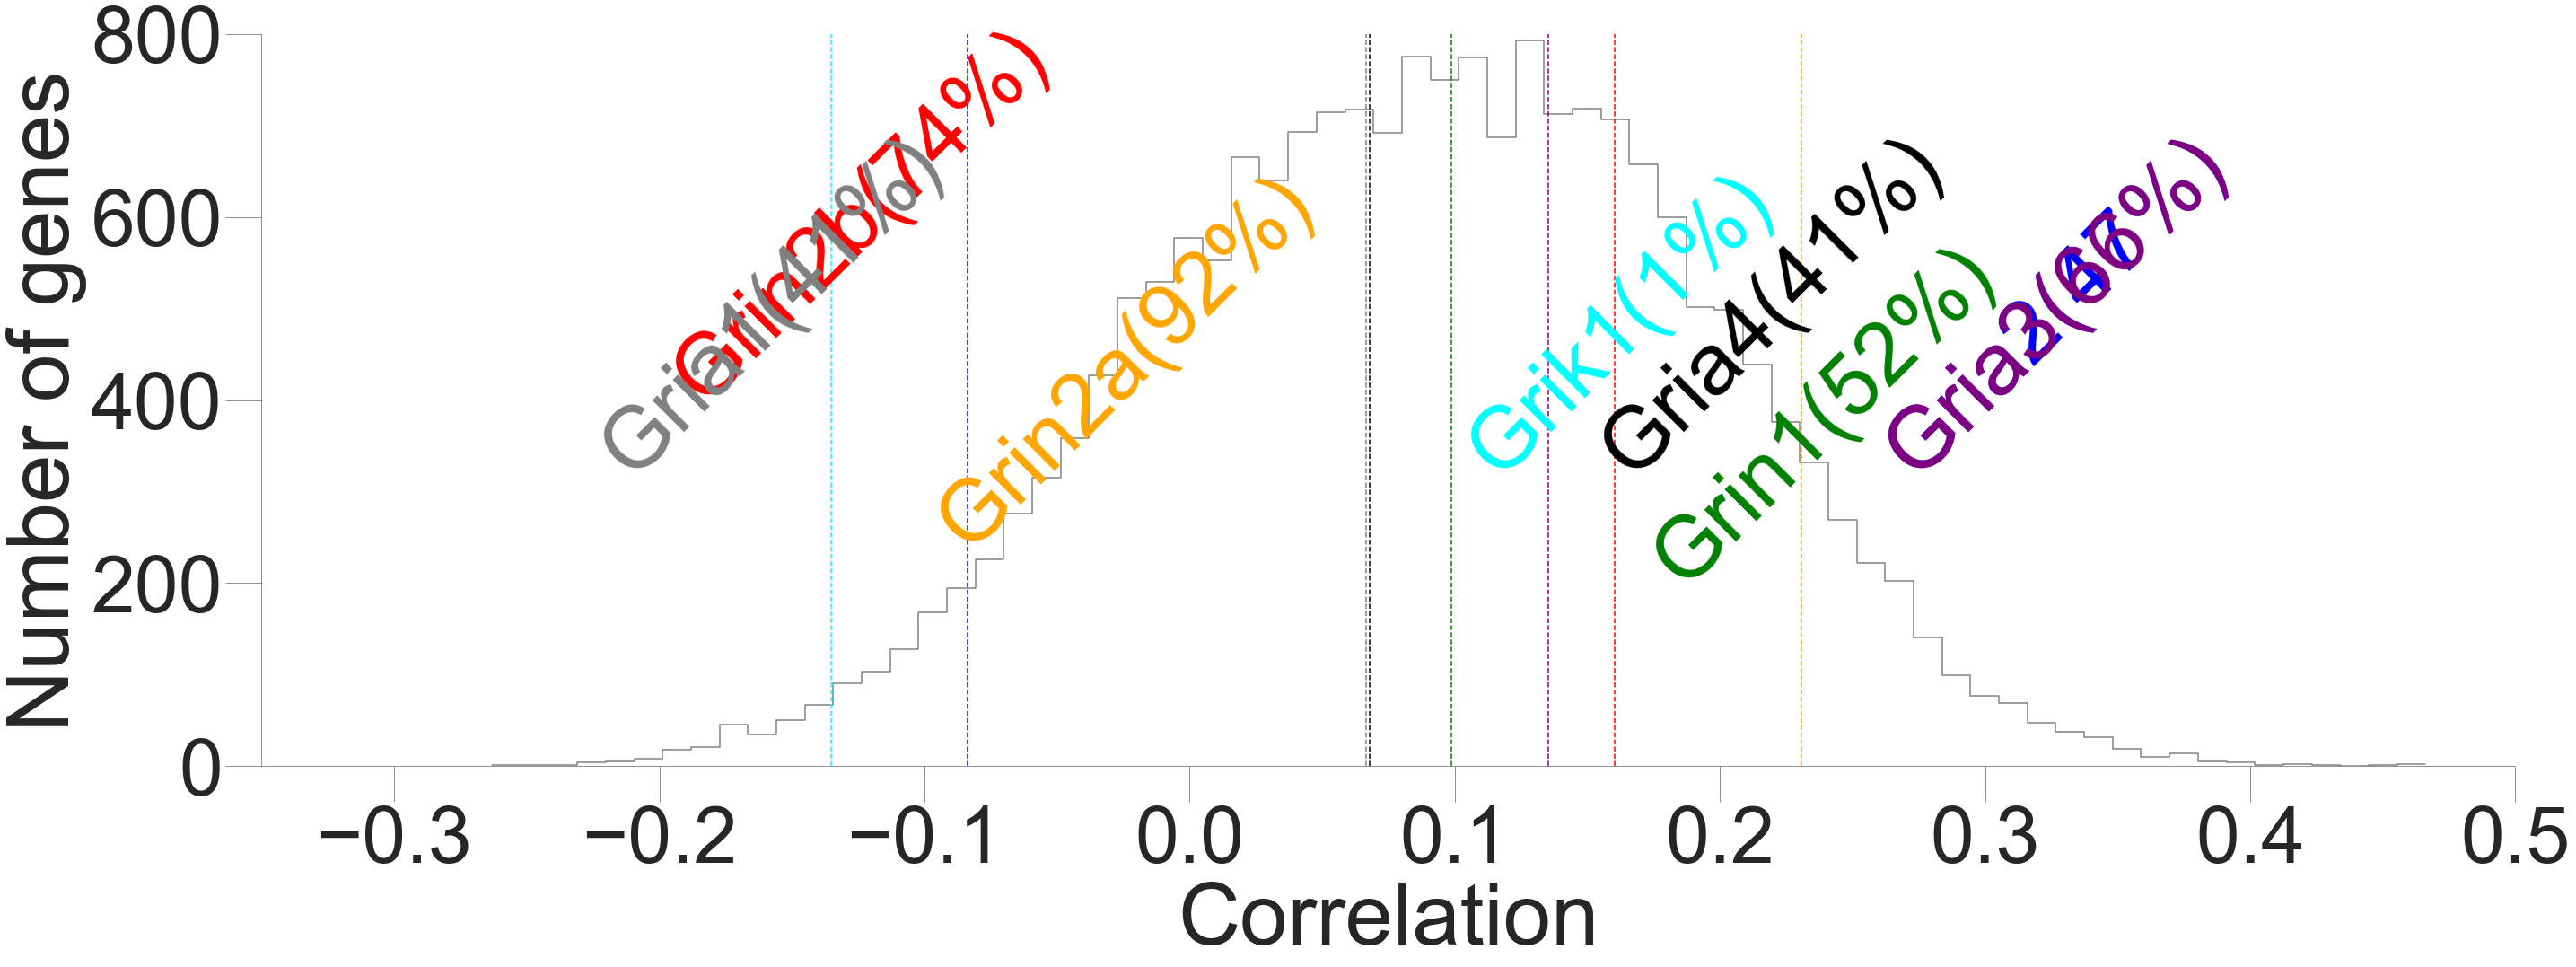

In [33]:
#plot main figure for all genes
plt.figure(figsize=(45,15))
sns.set(style="ticks", font_scale=8)

ax = sns.histplot(data=psi_all_correlations, x="correlation", element = 'step', fill=False, color='grey')
sns.despine()

trans = ax.get_xaxis_transform()

#Gria2
plt.axvline(x=-0.083802738, color='blue', linestyle='--')
plt.text(0.257424, .4, 'Gria2(47%)', transform=trans, color='blue', rotation=45)

#Grin2b
plt.axvline(x=0.160467967, color='red', linestyle='--')
plt.text(-0.2, .5, 'Grin2b(74%)', transform=trans, color='red', rotation=45)

#Grin1
plt.axvline(x=0.09880141, color='green', linestyle='--', lw=1.5)
plt.text(0.169885, .25, 'Grin1(52%)', transform=trans, color='green', rotation=45)

#Grin2a
plt.axvline(x=0.230657302, color='orange', linestyle='--', lw=1.5)
plt.text(-0.10, .3, 'Grin2a(92%)', transform=trans, color='orange', rotation=45)

#Gria1
plt.axvline(x=0.066402776, color='grey', linestyle='--', lw=1.5)
plt.text(-0.227017, .4, 'Gria1(41%)', transform=trans, color='grey', rotation=45)

#Gria3
plt.axvline(x=0.135135508, color='purple', linestyle='--', lw=1.5)
plt.text(0.257424, .4, 'Gria3(66%)', transform=trans, color='purple', rotation=45)

#Gria4
plt.axvline(x=0.06782872, color='black', linestyle='--', lw=1.5)
plt.text(0.15, .4, 'Gria4(41%)', transform=trans, color='black', rotation=45)

#Grik1
plt.axvline(x=-0.135159251, color='cyan', linestyle='--', lw=1.5)
plt.text(0.1, .4, 'Grik1(1%)', transform=trans, color='cyan', rotation=45)

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlim(-0.35,0.5)
plt.ylim(0,800)


ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlabel('Correlation')
plt.ylabel('Number of genes')

#### Fig 4C: Genes x all brain (ketamine)

Text(0, 0.5, 'Number of genes')

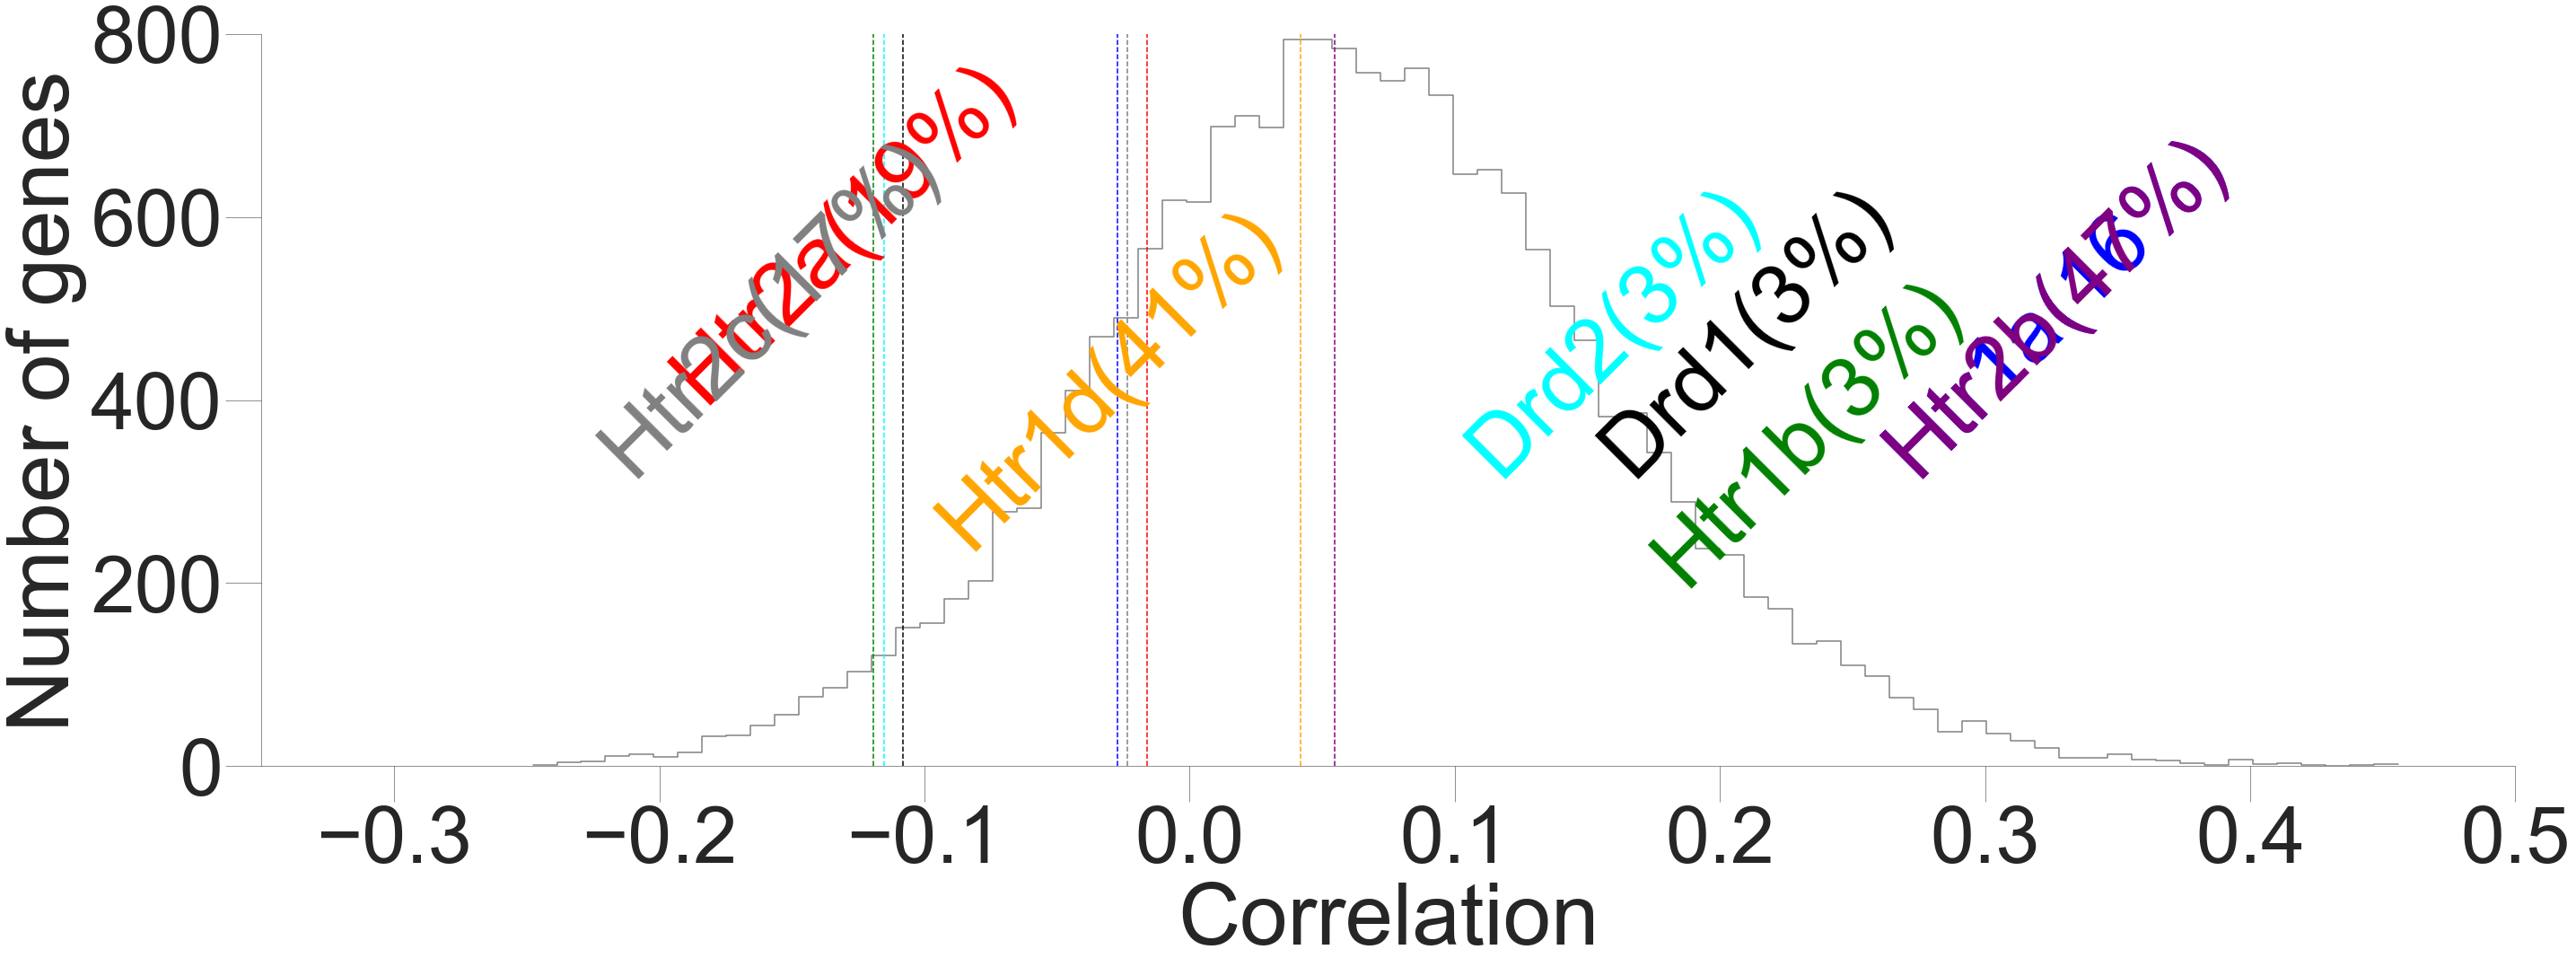

In [34]:
#plot main figure for all genes
plt.figure(figsize=(45,15))
sns.set(style="ticks", font_scale=8)

ax = sns.histplot(data=ket_all_correlations, x="correlation", element = 'step', fill=False, color='grey')
sns.despine()

trans = ax.get_xaxis_transform()

#htr1a
plt.axvline(x=-0.027109151, color='blue', linestyle='--')
plt.text(0.257424, .4, 'Htr1a(16%)', transform=trans, color='blue', rotation=45)

#htr2a
plt.axvline(x=-0.016029003, color='red', linestyle='--')
plt.text(-0.2, .5, 'Htr2a(19%)', transform=trans, color='red', rotation=45)

#htr1b
plt.axvline(x=-0.11925378, color='green', linestyle='--', lw=1.5)
plt.text(0.169885, .25, 'Htr1b(3%)', transform=trans, color='green', rotation=45)

#htr1d
plt.axvline(x=0.041739612, color='orange', linestyle='--', lw=1.5)
plt.text(-0.10, .3, 'Htr1d(41%)', transform=trans, color='orange', rotation=45)

#htr2c
plt.axvline(x=-0.023455905, color='grey', linestyle='--', lw=1.5)
plt.text(-0.227017, .4, 'Htr2c(17%)', transform=trans, color='grey', rotation=45)

#htr2b
plt.axvline(x=0.054742277, color='purple', linestyle='--', lw=1.5)
plt.text(0.257424, .4, 'Htr2b(47%)', transform=trans, color='purple', rotation=45)

#drd1
plt.axvline(x=-0.107991774, color='black', linestyle='--', lw=1.5)
plt.text(0.15, .4, 'Drd1(3%)', transform=trans, color='black', rotation=45)

#drd2
plt.axvline(x=-0.11527335, color='cyan', linestyle='--', lw=1.5)
plt.text(0.1, .4, 'Drd2(3%)', transform=trans, color='cyan', rotation=45)

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlim(-0.35,0.5)
plt.ylim(0,800)

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlabel('Correlation')
plt.ylabel('Number of genes')

#### Fig 4E: glutamate genes x whole brain (ketamine)

Text(0, 0.5, 'Number of genes')

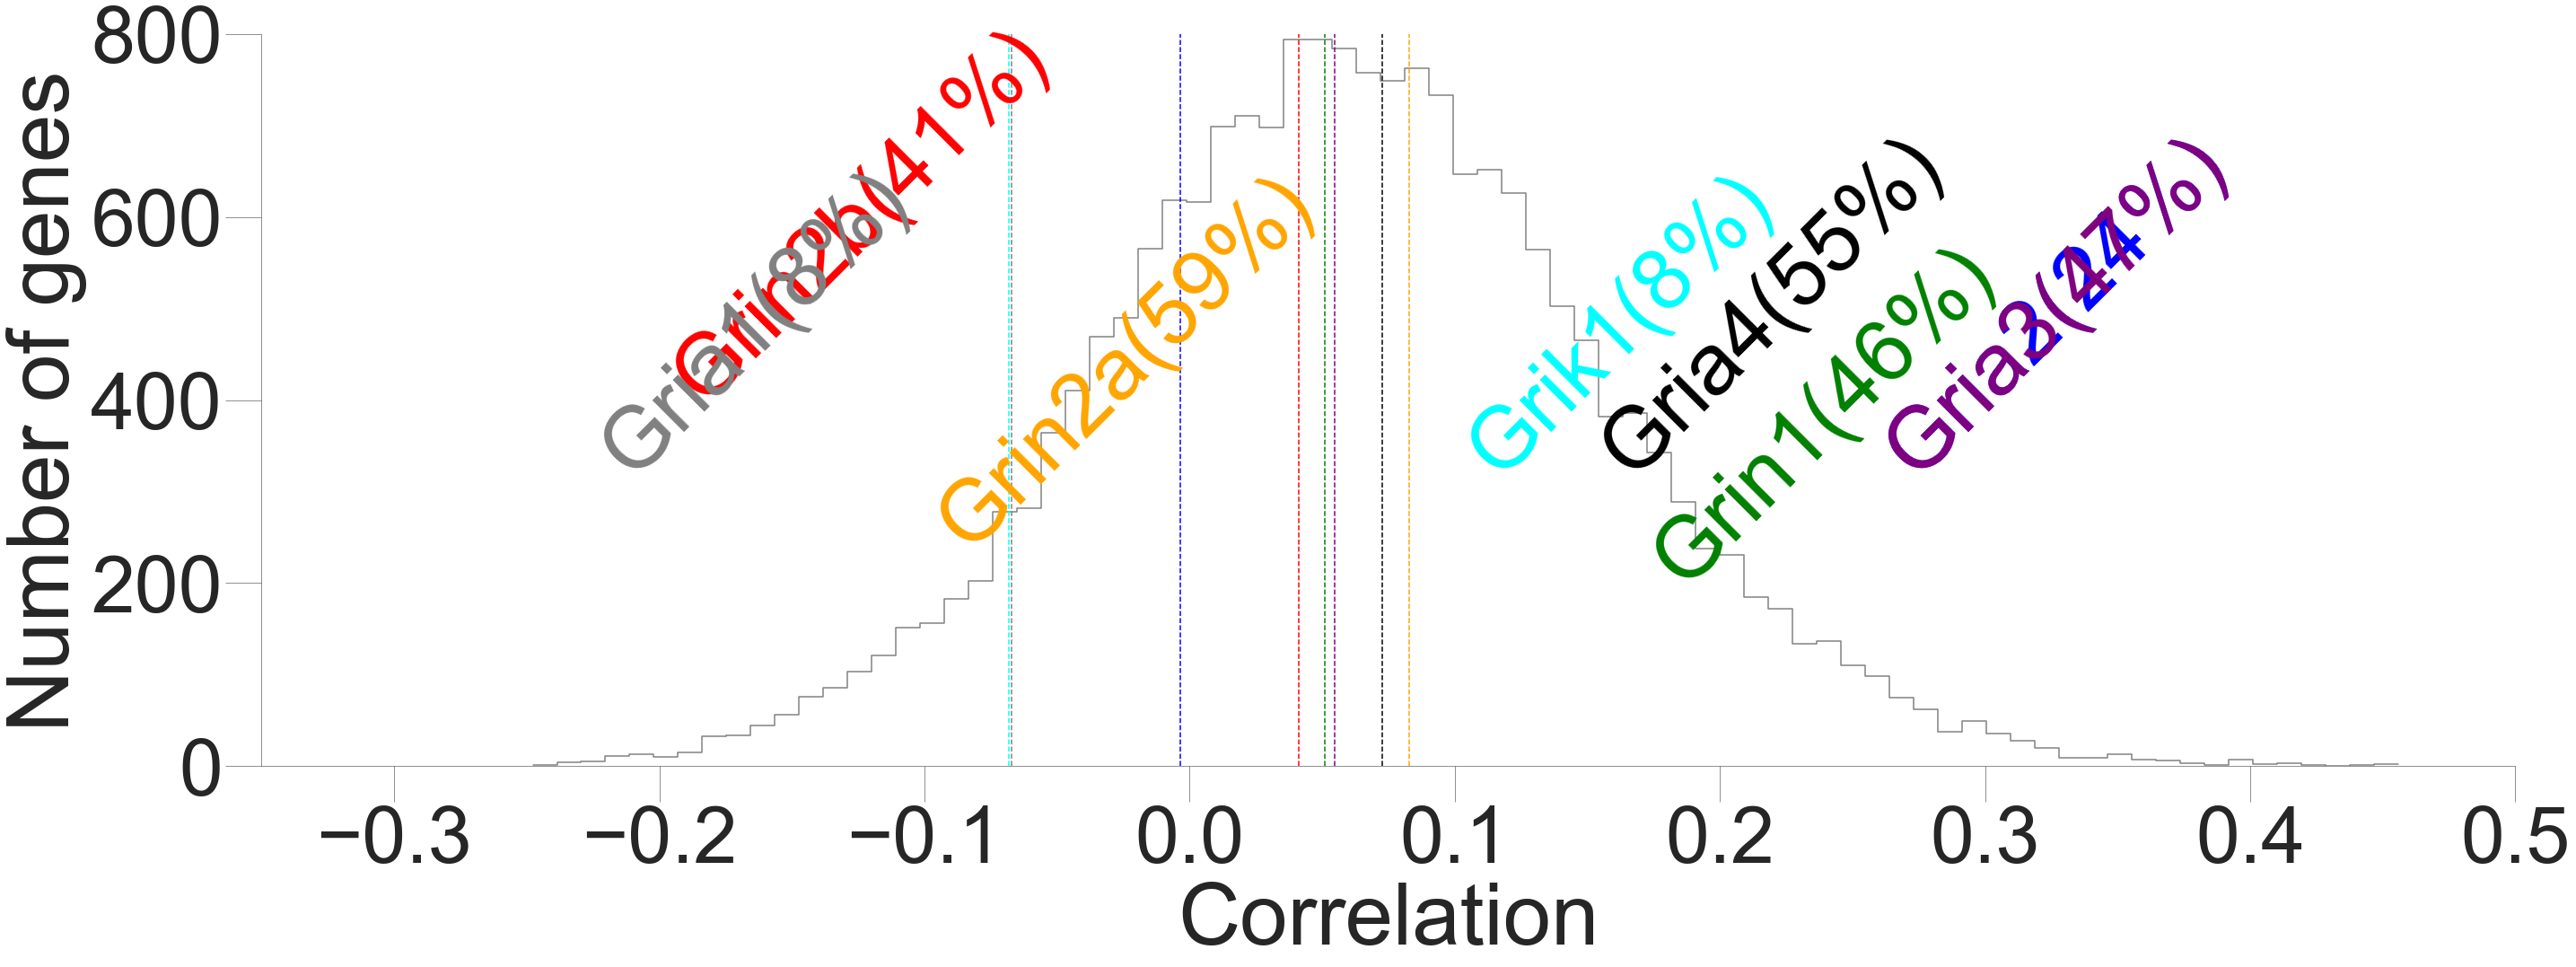

In [35]:
#plot main figure for all genes
plt.figure(figsize=(45,15))
sns.set(style="ticks", font_scale=8)

ax = sns.histplot(data=ket_all_correlations, x="correlation", element = 'step', fill=False, color='grey')
sns.despine()

trans = ax.get_xaxis_transform()

#Gria2
plt.axvline(x=-0.003503886, color='blue', linestyle='--')
plt.text(0.257424, .4, 'Gria2(24%)', transform=trans, color='blue', rotation=45)

#Grin2b
plt.axvline(x=0.041100866, color='red', linestyle='--')
plt.text(-0.2, .5, 'Grin2b(41%)', transform=trans, color='red', rotation=45)

#Grin1
plt.axvline(x=0.050947548, color='green', linestyle='--', lw=1.5)
plt.text(0.169885, .25, 'Grin1(46%)', transform=trans, color='green', rotation=45)

#Grin2a
plt.axvline(x=0.082738694, color='orange', linestyle='--', lw=1.5)
plt.text(-0.10, .3, 'Grin2a(59%)', transform=trans, color='orange', rotation=45)

#Gria1
plt.axvline(x=-0.067056712, color='grey', linestyle='--', lw=1.5)
plt.text(-0.227017, .4, 'Gria1(8%)', transform=trans, color='grey', rotation=45)

#Gria3
plt.axvline(x=0.054614056, color='purple', linestyle='--', lw=1.5)
plt.text(0.257424, .4, 'Gria3(47%)', transform=trans, color='purple', rotation=45)

#Gria4
plt.axvline(x=0.07258209, color='black', linestyle='--', lw=1.5)
plt.text(0.15, .4, 'Gria4(55%)', transform=trans, color='black', rotation=45)

#Grik1
plt.axvline(x=-0.068162532, color='cyan', linestyle='--', lw=1.5)
plt.text(0.1, .4, 'Grik1(8%)', transform=trans, color='cyan', rotation=45)

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlim(-0.35,0.5)
plt.ylim(0,800)


ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlabel('Correlation')
plt.ylabel('Number of genes')

### Cell type correlation (cortex only)

In [21]:
cfos_x_genes_ctx = cfos_x_genes[cfos_x_genes['Brain Area'] == 'Cortex']
list_of_genes = cfos_x_genes.gene_acronym.unique()
ctx_cell_type_correlations = []

#psilocybin
for gene in list_of_genes:
    cfos_x_genes_of_interest = cfos_x_genes_ctx[cfos_x_genes_ctx['gene_acronym'] == gene]
    correlation = cfos_x_genes_of_interest['zscore'].corr(cfos_x_genes_of_interest['psi-sal'])
    ctx_cell_type_correlations.append([gene, correlation])
    
ctx_cell_type_correlations = pd.DataFrame(ctx_cell_type_correlations, columns=['gene', 'correlation'])

#ketamine
cfos_x_genes_ctx = cfos_x_genes[cfos_x_genes['Brain Area'] == 'Cortex']
list_of_genes = cfos_x_genes.gene_acronym.unique()
ket_ctx_cell_type_correlations = []

for gene in list_of_genes:
    cfos_x_genes_of_interest = cfos_x_genes_ctx[cfos_x_genes_ctx['gene_acronym'] == gene]
    correlation = cfos_x_genes_of_interest['zscore'].corr(cfos_x_genes_of_interest['ket-sal'])
    ket_ctx_cell_type_correlations.append([gene, correlation])
    
ket_ctx_cell_type_correlations = pd.DataFrame(ket_ctx_cell_type_correlations, columns=['gene', 'correlation'])

### Cortex percentiles

In [23]:
#psilocybin brain wide
ctx_cell_type_correlations['percentile'] = ctx_cell_type_correlations.correlation.rank(pct = True)
ctx_cell_type_correlations.sort_values(by=['percentile'], ascending=False, inplace=True)

#ketamine brain wide
ket_ctx_cell_type_correlations['percentile'] = ket_ctx_cell_type_correlations.correlation.rank(pct = True)
ket_ctx_cell_type_correlations.sort_values(by=['percentile'], ascending=False, inplace=True)

#list genes of interest for correlation
geneList = ['Htr1a','Htr1b','Htr1d','Htr1f','Htr2a','Htr2b','Htr2c','Htr3a','Htr3b','Htr4','Htr5a','Htr5b','Htr6','Htr7','Slc6a4',
            'Pvalb', 'Sst', 'Vip', 'Sncg', 'Lamp5', 'Slc17a7', 'Plxnd1', 'Fezf2', 'Gad1', 'Camk2a', 
            'Gria2', 'Grin2b', 'Grin1', 'Grin2a', 'Gria1', 'Gria3', 'Gria4', 'Grik1',
            'Adra2a', 'Adra2b', 'Hrh1', 
            'Drd1', 'Drd2', 'Drd3', 'Oprm1']

genes_of_interest = ket_ctx_cell_type_correlations[ket_ctx_cell_type_correlations['gene'].isin(geneList)]

In [24]:
#list genes of interest for correlation
geneList = ['Htr1a','Htr1b','Htr1d','Htr1f','Htr2a','Htr2b','Htr2c','Htr3a','Htr3b','Htr4','Htr5a','Htr5b','Htr6','Htr7','Slc6a4',
            'Pvalb', 'Sst', 'Vip', 'Sncg', 'Lamp5', 'Slc17a7', 'Plxnd1', 'Fezf2', 'Gad1', 'Camk2a', 
            'Gria2', 'Grin2b', 'Grin1', 'Grin2a', 'Gria1', 'Gria3', 'Gria4', 'Grik1',
            'Adra2a', 'Adra2b', 'Hrh1', 
            'Drd1', 'Drd2', 'Drd3', 'Oprm1']

genes_of_interest = ket_ctx_cell_type_correlations[ket_ctx_cell_type_correlations['gene'].isin(geneList)]

#### Fig 4F: Cortex x Receptors (Psilocybin)

Text(0, 0.5, 'Number of genes')

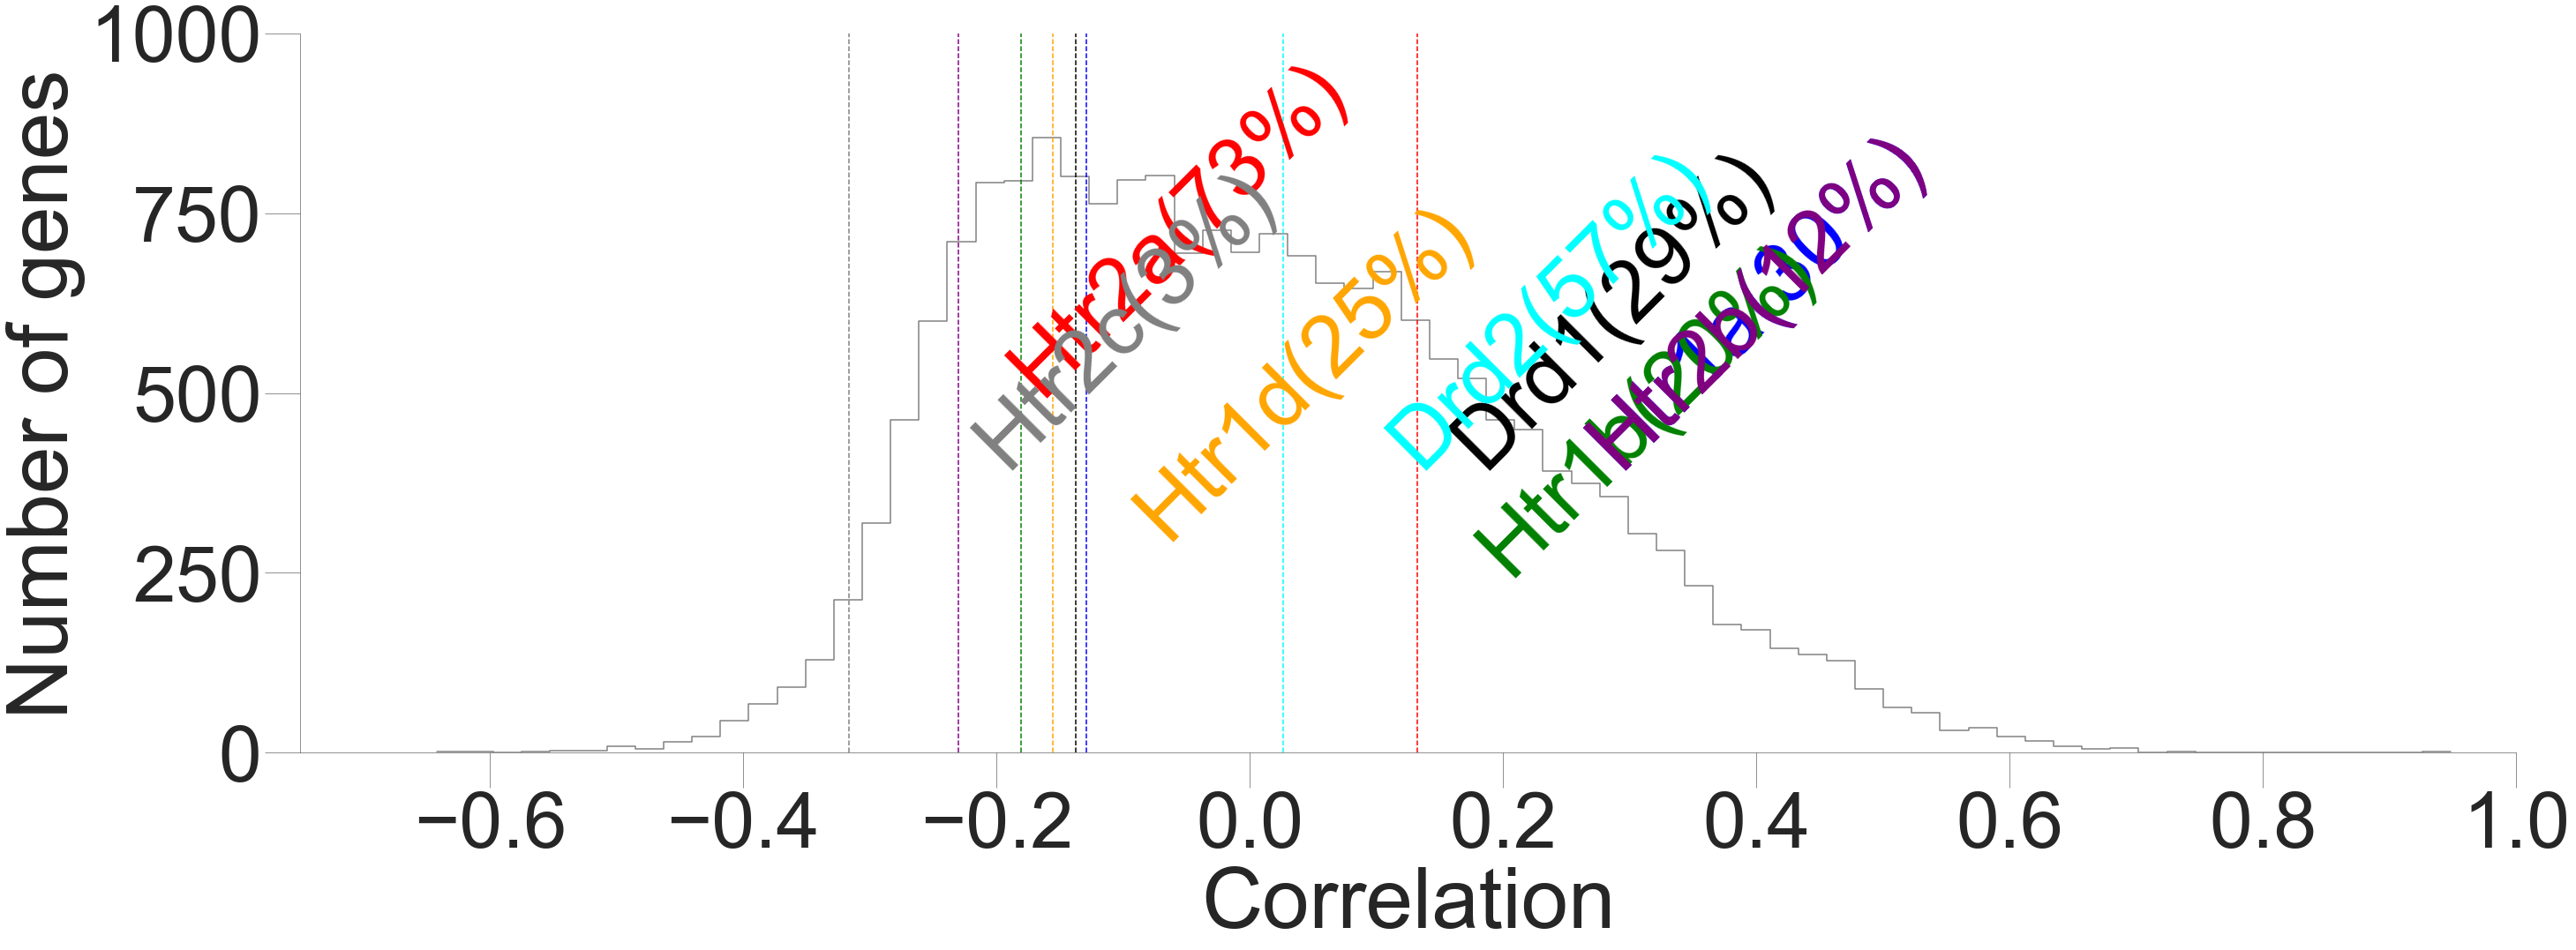

In [36]:
#plot main figure for all genes
plt.figure(figsize=(45,15))
sns.set(style="ticks", font_scale=8)

ax = sns.histplot(data=ctx_cell_type_correlations, x="correlation", element = 'step', fill=False, color='grey')
sns.despine()

trans = ax.get_xaxis_transform()

#htr1a
plt.axvline(x=-0.12933488, color='blue', linestyle='--')
plt.text(0.257424, .4, 'Htr1a(30%)', transform=trans, color='blue', rotation=45)

#htr2a
plt.axvline(x=0.132179949, color='red', linestyle='--')
plt.text(-0.2, .5, 'Htr2a(73%)', transform=trans, color='red', rotation=45)

#htr1b
plt.axvline(x=-0.181087205, color='green', linestyle='--', lw=1.5)
plt.text(0.169885, .25, 'Htr1b(20%)', transform=trans, color='green', rotation=45)

#htr1d
plt.axvline(x=-0.155787593, color='orange', linestyle='--', lw=1.5)
plt.text(-0.10, .3, 'Htr1d(25%)', transform=trans, color='orange', rotation=45)

#htr2c
plt.axvline(x=-0.316388376, color='grey', linestyle='--', lw=1.5)
plt.text(-0.227017, .4, 'Htr2c(3%)', transform=trans, color='grey', rotation=45)

#htr2b
plt.axvline(x=-0.230107708, color='purple', linestyle='--', lw=1.5)
plt.text(0.257424, .4, 'Htr2b(12%)', transform=trans, color='purple', rotation=45)

#drd1
plt.axvline(x=-0.137461821, color='black', linestyle='--', lw=1.5)
plt.text(0.15, .4, 'Drd1(29%)', transform=trans, color='black', rotation=45)

#drd2
plt.axvline(x=0.026395372, color='cyan', linestyle='--', lw=1.5)
plt.text(0.1, .4, 'Drd2(57%)', transform=trans, color='cyan', rotation=45)

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlim(-0.75,1.0)
plt.ylim(0,1000)

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlabel('Correlation')
plt.ylabel('Number of genes')

#### Fig 4H: cortex x glutamate receptors (psilocybin)

Text(0, 0.5, 'Number of genes')

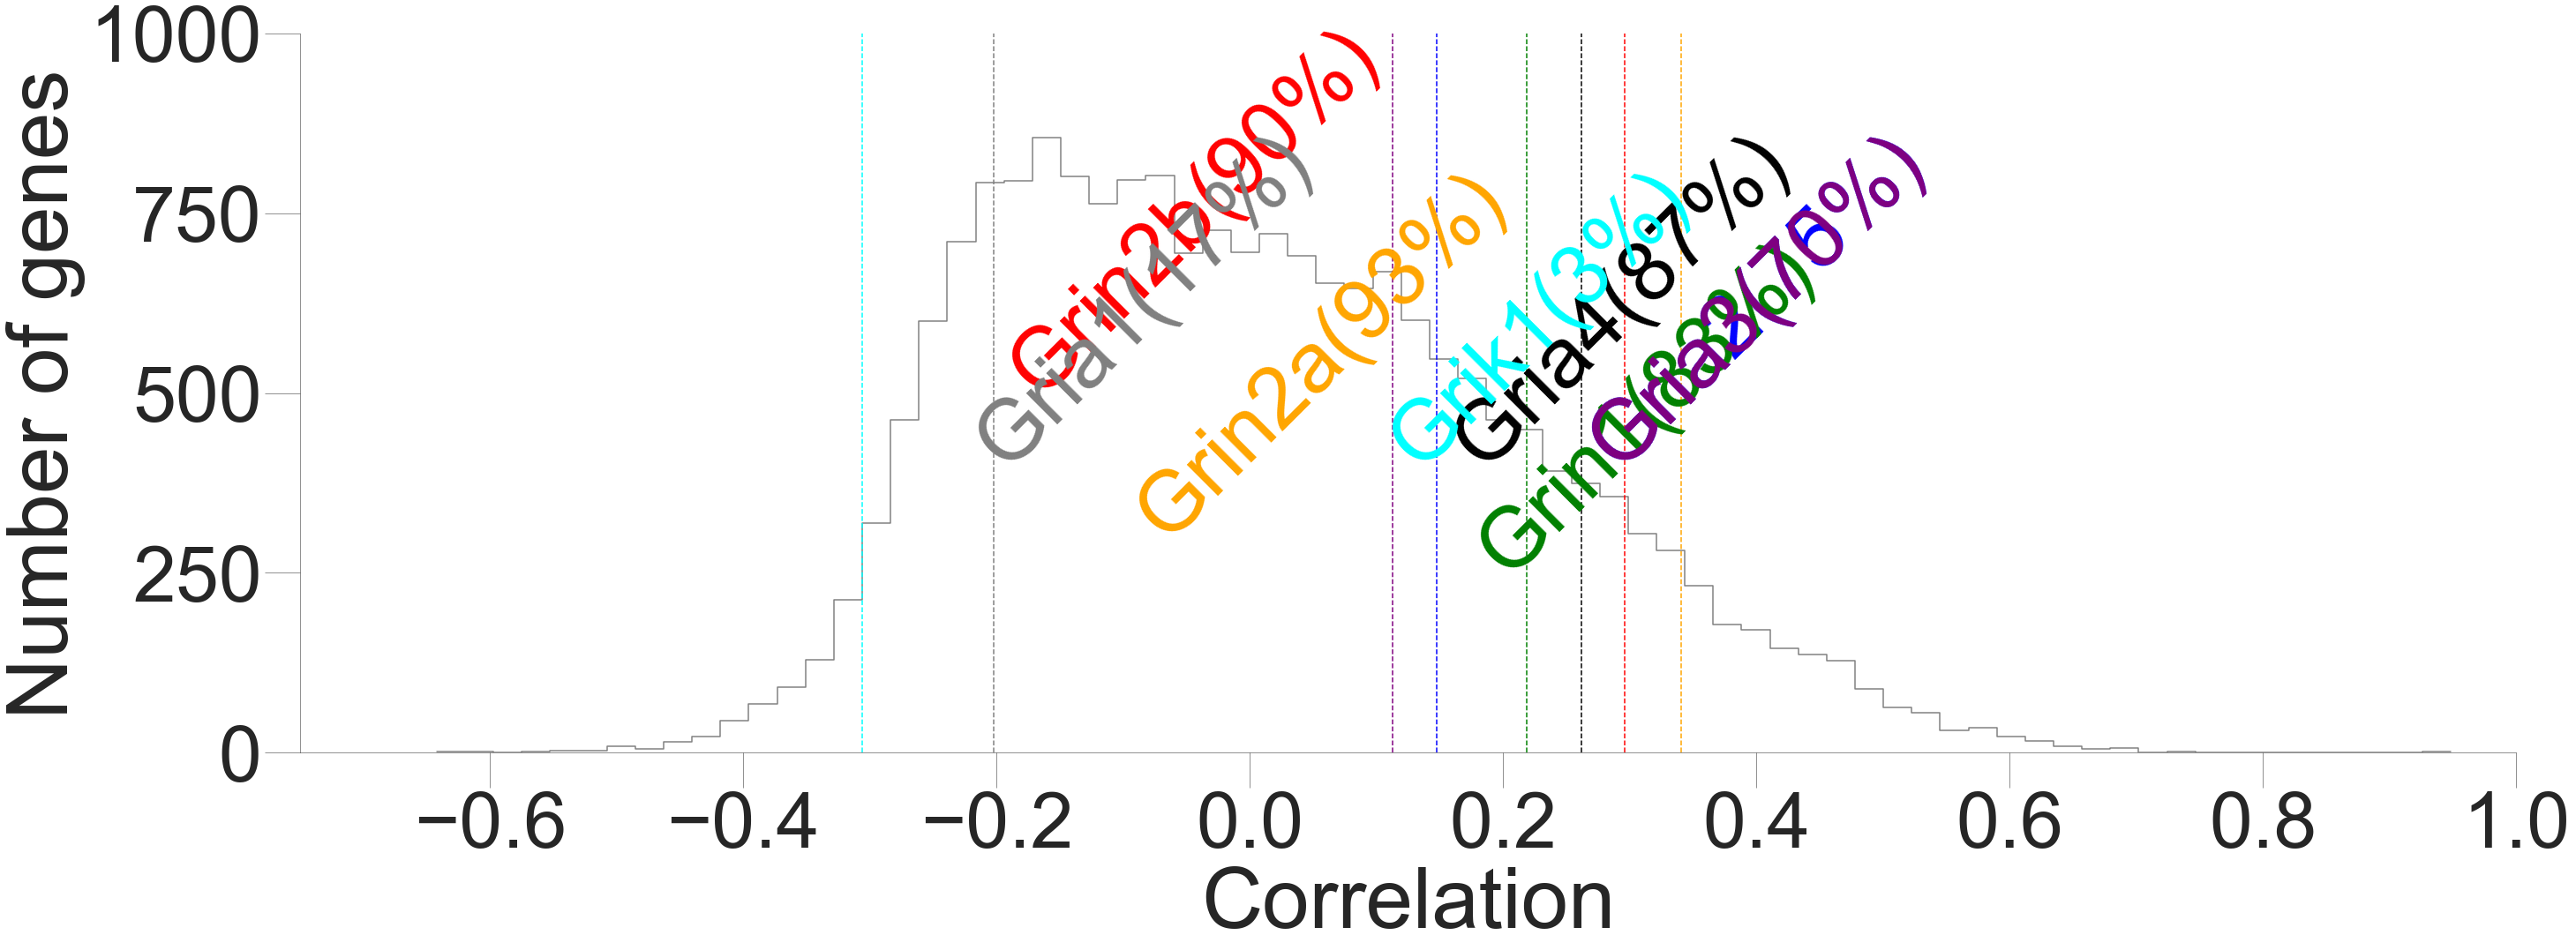

In [37]:
#plot main figure for all genes
plt.figure(figsize=(45,15))
sns.set(style="ticks", font_scale=8)

ax = sns.histplot(data=ctx_cell_type_correlations, x="correlation", element = 'step', fill=False, color='grey')
sns.despine()

trans = ax.get_xaxis_transform()

#Gria2
plt.axvline(x=0.147628289, color='blue', linestyle='--')
plt.text(0.257424, .4, 'Gria2(75%)', transform=trans, color='blue', rotation=45)

#Grin2b
plt.axvline(x=0.296214581, color='red', linestyle='--')
plt.text(-0.2, .5, 'Grin2b(90%)', transform=trans, color='red', rotation=45)

#Grin1
plt.axvline(x=0.218489957, color='green', linestyle='--', lw=1.5)
plt.text(0.169885, .25, 'Grin1(83%)', transform=trans, color='green', rotation=45)

#Grin2a
plt.axvline(x=0.340279687, color='orange', linestyle='--', lw=1.5)
plt.text(-0.10, .3, 'Grin2a(93%)', transform=trans, color='orange', rotation=45)

#Gria1
plt.axvline(x=-0.202178601, color='grey', linestyle='--', lw=1.5)
plt.text(-0.227017, .4, 'Gria1(17%)', transform=trans, color='grey', rotation=45)

#Gria3
plt.axvline(x=0.112561544, color='purple', linestyle='--', lw=1.5)
plt.text(0.257424, .4, 'Gria3(70%)', transform=trans, color='purple', rotation=45)

#Gria4
plt.axvline(x=0.261686255, color='black', linestyle='--', lw=1.5)
plt.text(0.15, .4, 'Gria4(87%)', transform=trans, color='black', rotation=45)

#Grik1
plt.axvline(x=-0.306170789, color='cyan', linestyle='--', lw=1.5)
plt.text(0.1, .4, 'Grik1(3%)', transform=trans, color='cyan', rotation=45)

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlim(-0.75,1.0)
plt.ylim(0,1000)


ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlabel('Correlation')
plt.ylabel('Number of genes')

#### Fig 4G: Cortex x Receptors (Ketamine)

(0.0, 1000.0)

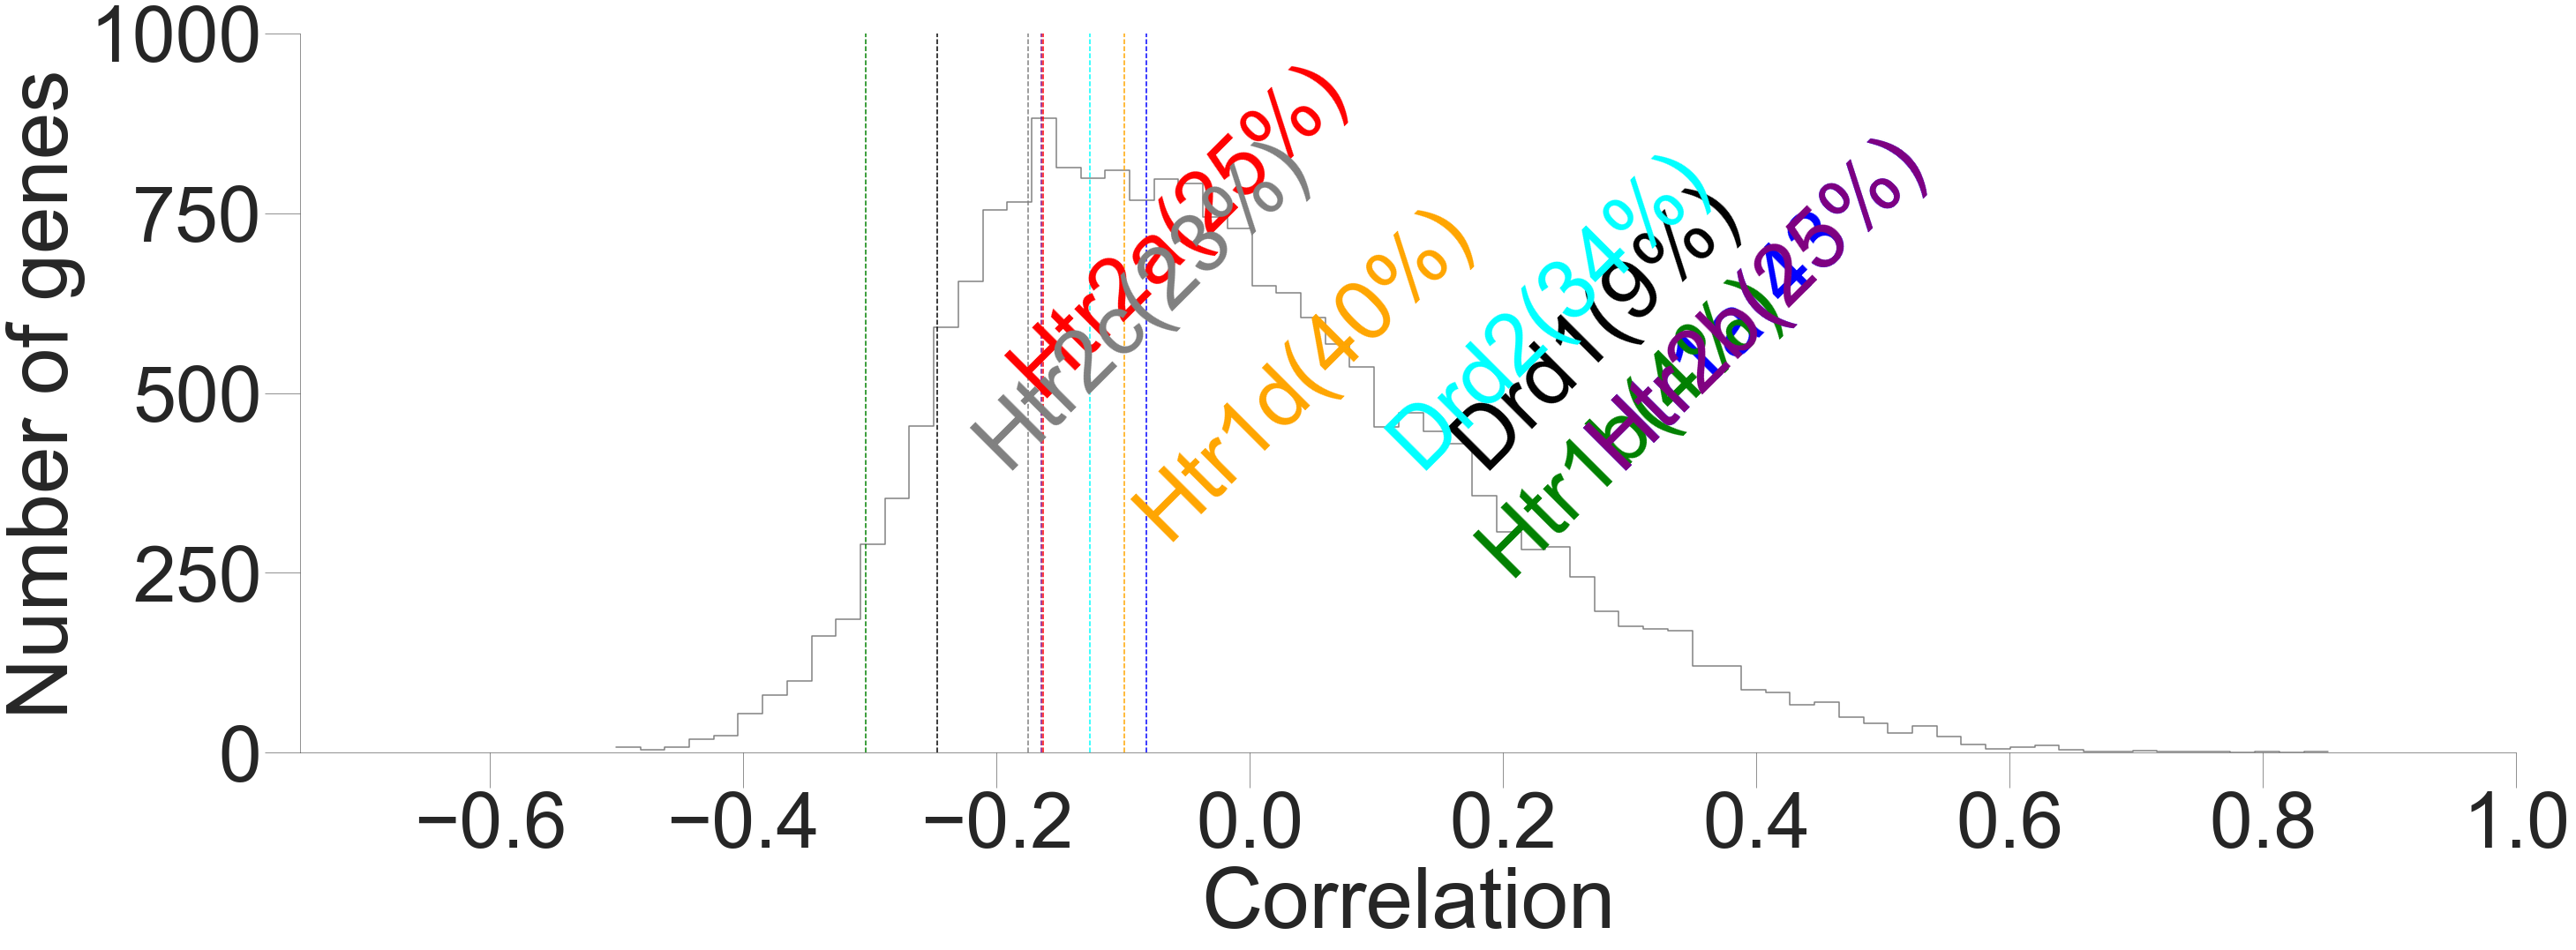

In [38]:
#plot main figure for all genes
plt.figure(figsize=(45,15))
sns.set(style="ticks", font_scale=8)

ax = sns.histplot(data=ket_ctx_cell_type_correlations, x="correlation", element = 'step', fill=False, color='grey')
sns.despine()

trans = ax.get_xaxis_transform()

#htr1a
plt.axvline(x=-0.082068191, color='blue', linestyle='--')
plt.text(0.257424, .4, 'Htr1a(43%)', transform=trans, color='blue', rotation=45)

#htr2a
plt.axvline(x=-0.163455369, color='red', linestyle='--')
plt.text(-0.2, .5, 'Htr2a(25%)', transform=trans, color='red', rotation=45)

#htr1b
plt.axvline(x=-0.303404465, color='green', linestyle='--', lw=1.5)
plt.text(0.169885, .25, 'Htr1b(4%)', transform=trans, color='green', rotation=45)

#htr1d
plt.axvline(x=-0.099034723, color='orange', linestyle='--', lw=1.5)
plt.text(-0.10, .3, 'Htr1d(40%)', transform=trans, color='orange', rotation=45)

#htr2c
plt.axvline(x=-0.175008045, color='grey', linestyle='--', lw=1.5)
plt.text(-0.227017, .4, 'Htr2c(23%)', transform=trans, color='grey', rotation=45)

#htr2b
plt.axvline(x=-0.164931939, color='purple', linestyle='--', lw=1.5)
plt.text(0.257424, .4, 'Htr2b(25%)', transform=trans, color='purple', rotation=45)

#drd1
plt.axvline(x=-0.246682821, color='black', linestyle='--', lw=1.5)
plt.text(0.15, .4, 'Drd1(9%)', transform=trans, color='black', rotation=45)

#drd2
plt.axvline(x=-0.126374672, color='cyan', linestyle='--', lw=1.5)
plt.text(0.1, .4, 'Drd2(34%)', transform=trans, color='cyan', rotation=45)

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlabel('Correlation')
plt.ylabel('Number of genes')
plt.xlim(-0.75,1.0)
plt.ylim(0,1000)

#### Fig 4I: cortex x glutamate receptors (ketamine)

Text(0, 0.5, 'Number of genes')

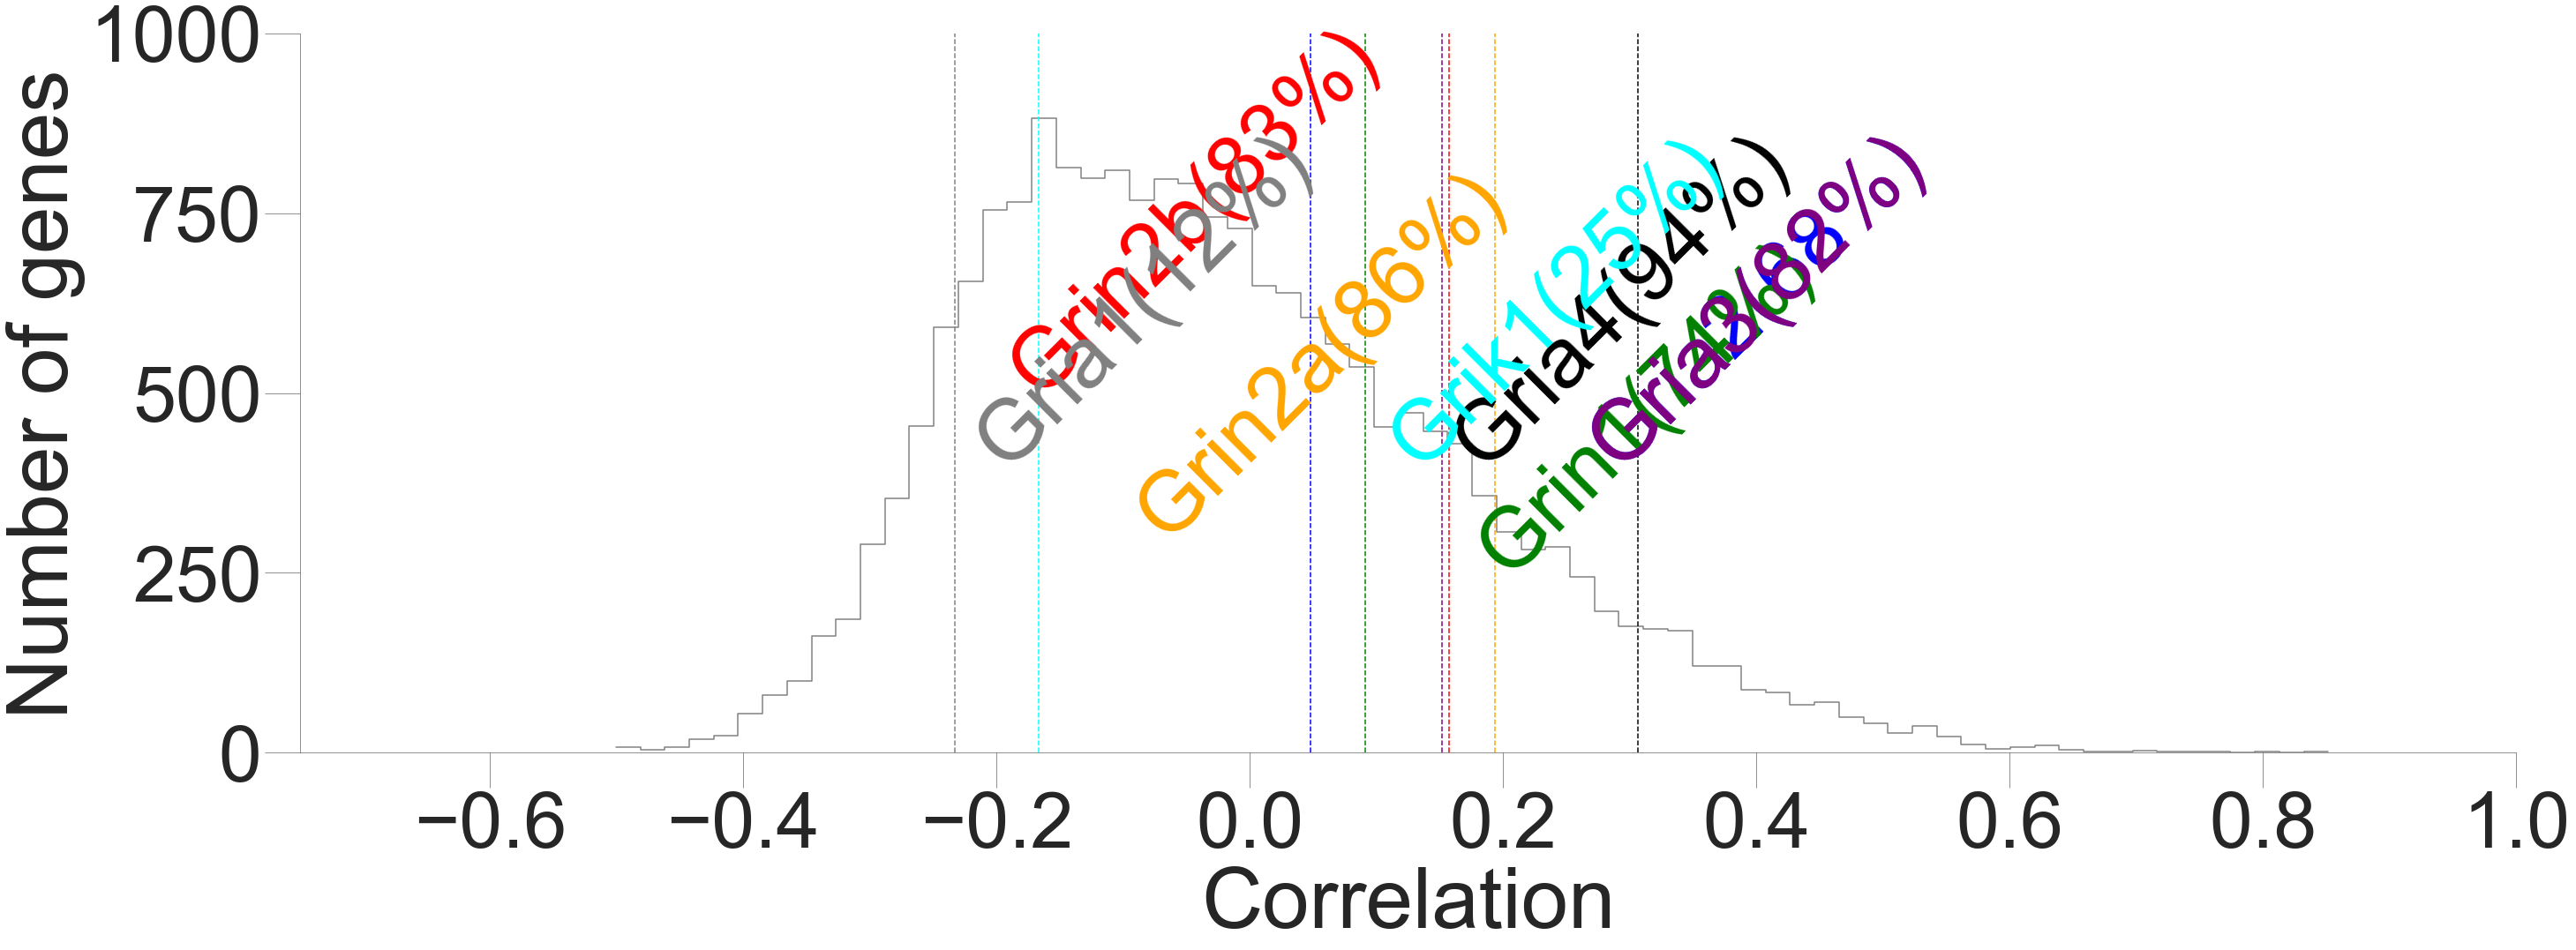

In [39]:
#plot main figure for all genes
plt.figure(figsize=(45,15))
sns.set(style="ticks", font_scale=8)

ax = sns.histplot(data=ket_ctx_cell_type_correlations, x="correlation", element = 'step', fill=False, color='grey')
sns.despine()

trans = ax.get_xaxis_transform()

#Gria2
plt.axvline(x=0.047782089, color='blue', linestyle='--')
plt.text(0.257424, .4, 'Gria2(68%)', transform=trans, color='blue', rotation=45)

#Grin2b
plt.axvline(x=0.157520283, color='red', linestyle='--')
plt.text(-0.2, .5, 'Grin2b(83%)', transform=trans, color='red', rotation=45)

#Grin1
plt.axvline(x=0.091328713, color='green', linestyle='--', lw=1.5)
plt.text(0.169885, .25, 'Grin1(74%)', transform=trans, color='green', rotation=45)

#Grin2a
plt.axvline(x=0.193640736, color='orange', linestyle='--', lw=1.5)
plt.text(-0.10, .3, 'Grin2a(86%)', transform=trans, color='orange', rotation=45)

#Gria1
plt.axvline(x=-0.232709678, color='grey', linestyle='--', lw=1.5)
plt.text(-0.227017, .4, 'Gria1(12%)', transform=trans, color='grey', rotation=45)

#Gria3
plt.axvline(x=0.151811055, color='purple', linestyle='--', lw=1.5)
plt.text(0.257424, .4, 'Gria3(82%)', transform=trans, color='purple', rotation=45)

#Gria4
plt.axvline(x=0.306731317, color='black', linestyle='--', lw=1.5)
plt.text(0.15, .4, 'Gria4(94%)', transform=trans, color='black', rotation=45)

#Grik1
plt.axvline(x=-0.166612383, color='cyan', linestyle='--', lw=1.5)
plt.text(0.1, .4, 'Grik1(25%)', transform=trans, color='cyan', rotation=45)

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlim(-0.75,1.0)
plt.ylim(0,1000)


ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlabel('Correlation')
plt.ylabel('Number of genes')

#### Figure 4J: Cortex x Cell Types (Psilocybin)

(0.0, 1000.0)

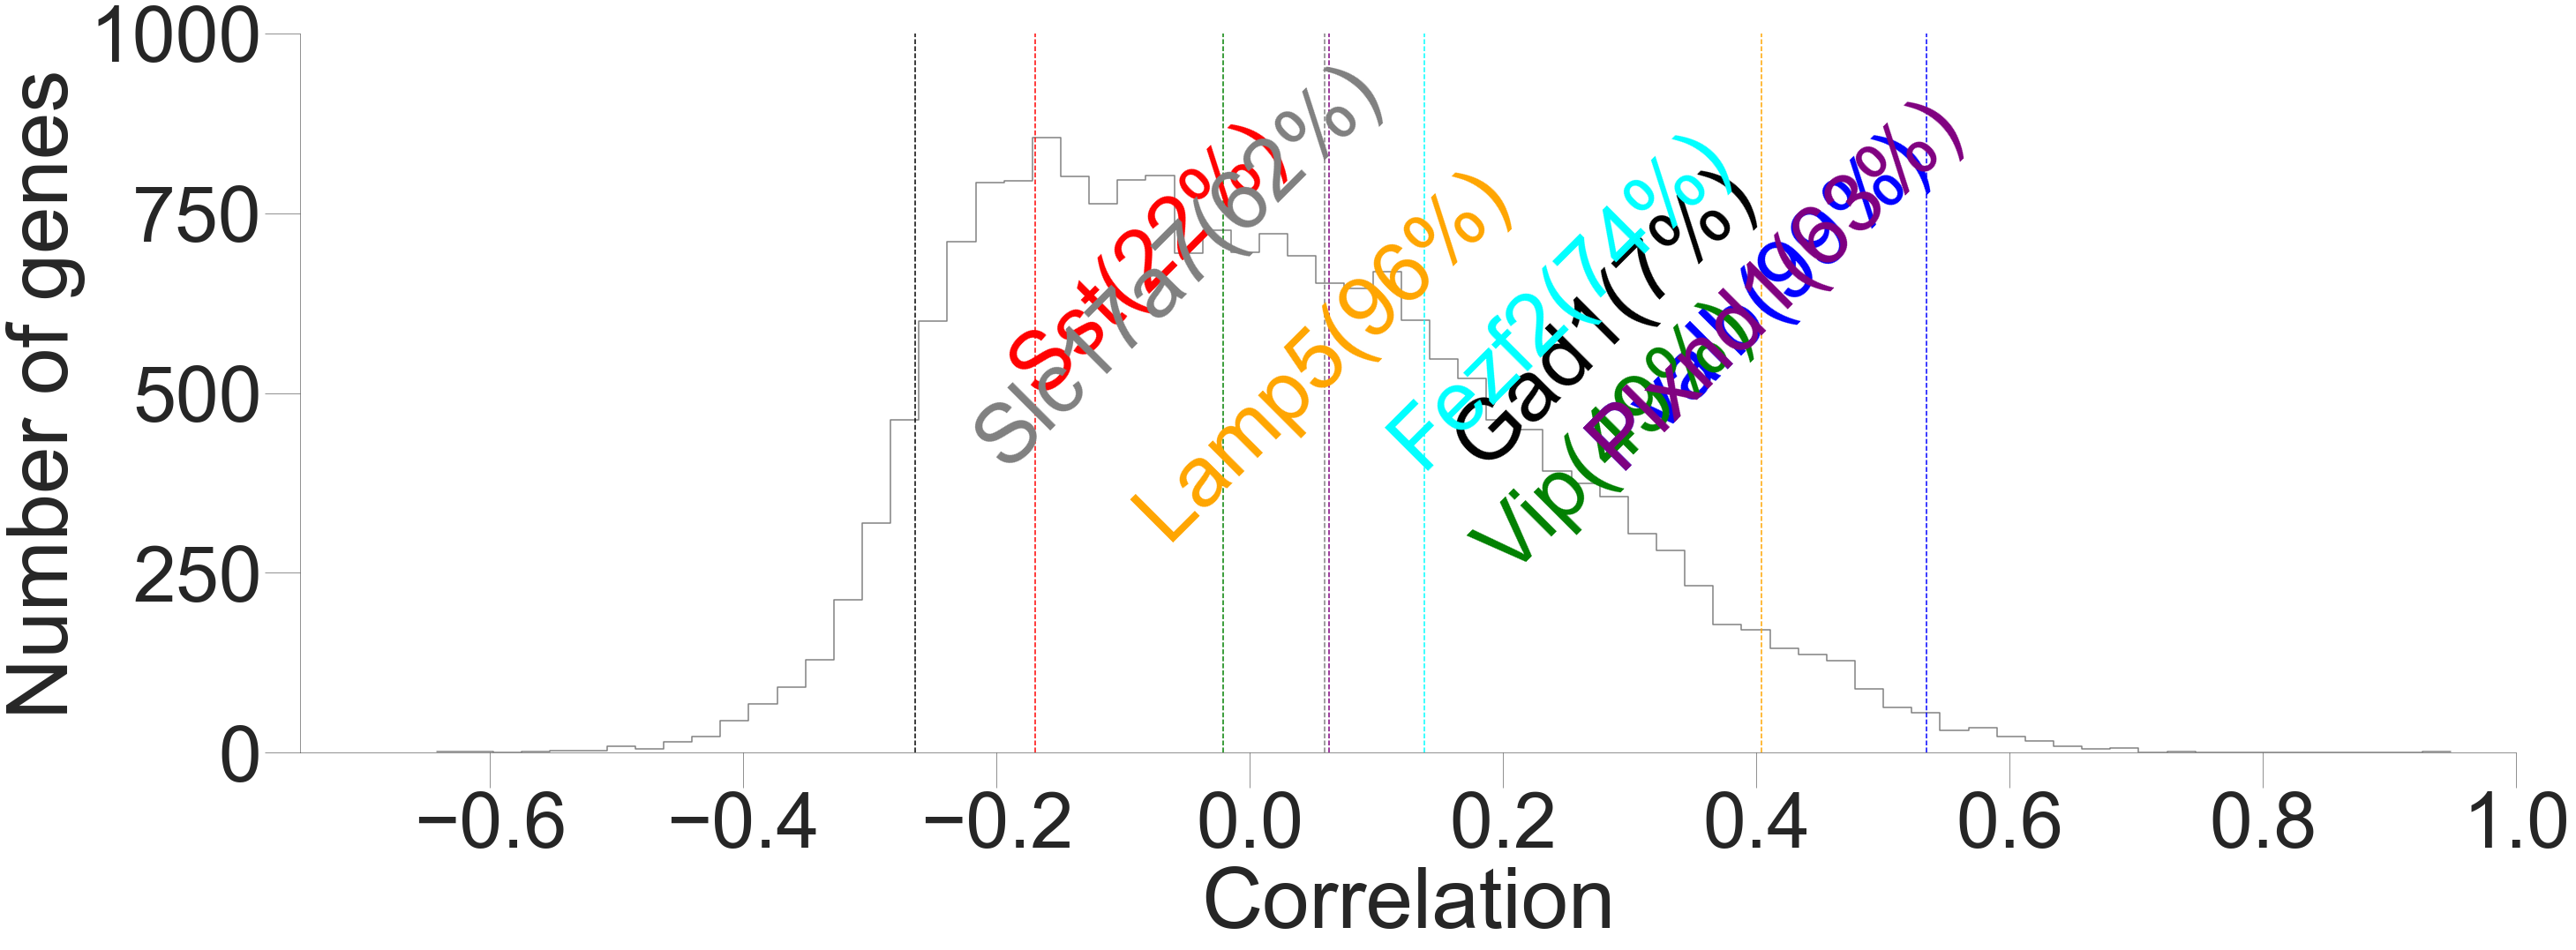

In [40]:
#plot main figure for all genes
plt.figure(figsize=(45,15))
sns.set(style="ticks", font_scale=8)

ax = sns.histplot(data=ctx_cell_type_correlations, x="correlation", element = 'step', fill=False, color='grey')
sns.despine()

trans = ax.get_xaxis_transform()

#pvalb
plt.axvline(x=0.534344412, color='blue', linestyle='--')
plt.text(0.257424, .4, 'Pvalb(99%)', transform=trans, color='blue', rotation=45)

#sst
plt.axvline(x=-0.169566359, color='red', linestyle='--')
plt.text(-0.2, .5, 'Sst(22%)', transform=trans, color='red', rotation=45)

#vip
plt.axvline(x=-0.020896758, color='green', linestyle='--', lw=1.5)
plt.text(0.169885, .25, 'Vip(49%)', transform=trans, color='green', rotation=45)

#lamp5
plt.axvline(x=0.404103011, color='orange', linestyle='--', lw=1.5)
plt.text(-0.10, .3, 'Lamp5(96%)', transform=trans, color='orange', rotation=45)

#slc17a7
plt.axvline(x=0.059172822, color='grey', linestyle='--', lw=1.5)
plt.text(-0.227017, .4, 'Slc17a7(62%)', transform=trans, color='grey', rotation=45)

#plxnd1
plt.axvline(x=0.062487062, color='purple', linestyle='--', lw=1.5)
plt.text(0.257424, .4, 'Plxnd1(63%)', transform=trans, color='purple', rotation=45)

#Gad1
plt.axvline(x=-0.264378069, color='black', linestyle='--', lw=1.5)
plt.text(0.15, .4, 'Gad1(7%)', transform=trans, color='black', rotation=45)

#Fezf2
plt.axvline(x=0.137999219, color='cyan', linestyle='--', lw=1.5)
plt.text(0.1, .4, 'Fezf2(74%)', transform=trans, color='cyan', rotation=45)

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlabel('Correlation')
plt.ylabel('Number of genes')
plt.xlim(-0.75,1.0)
plt.ylim(0,1000)

#### Figure 4J: Cortex x Cell Types (Ketamine)

(0.0, 1000.0)

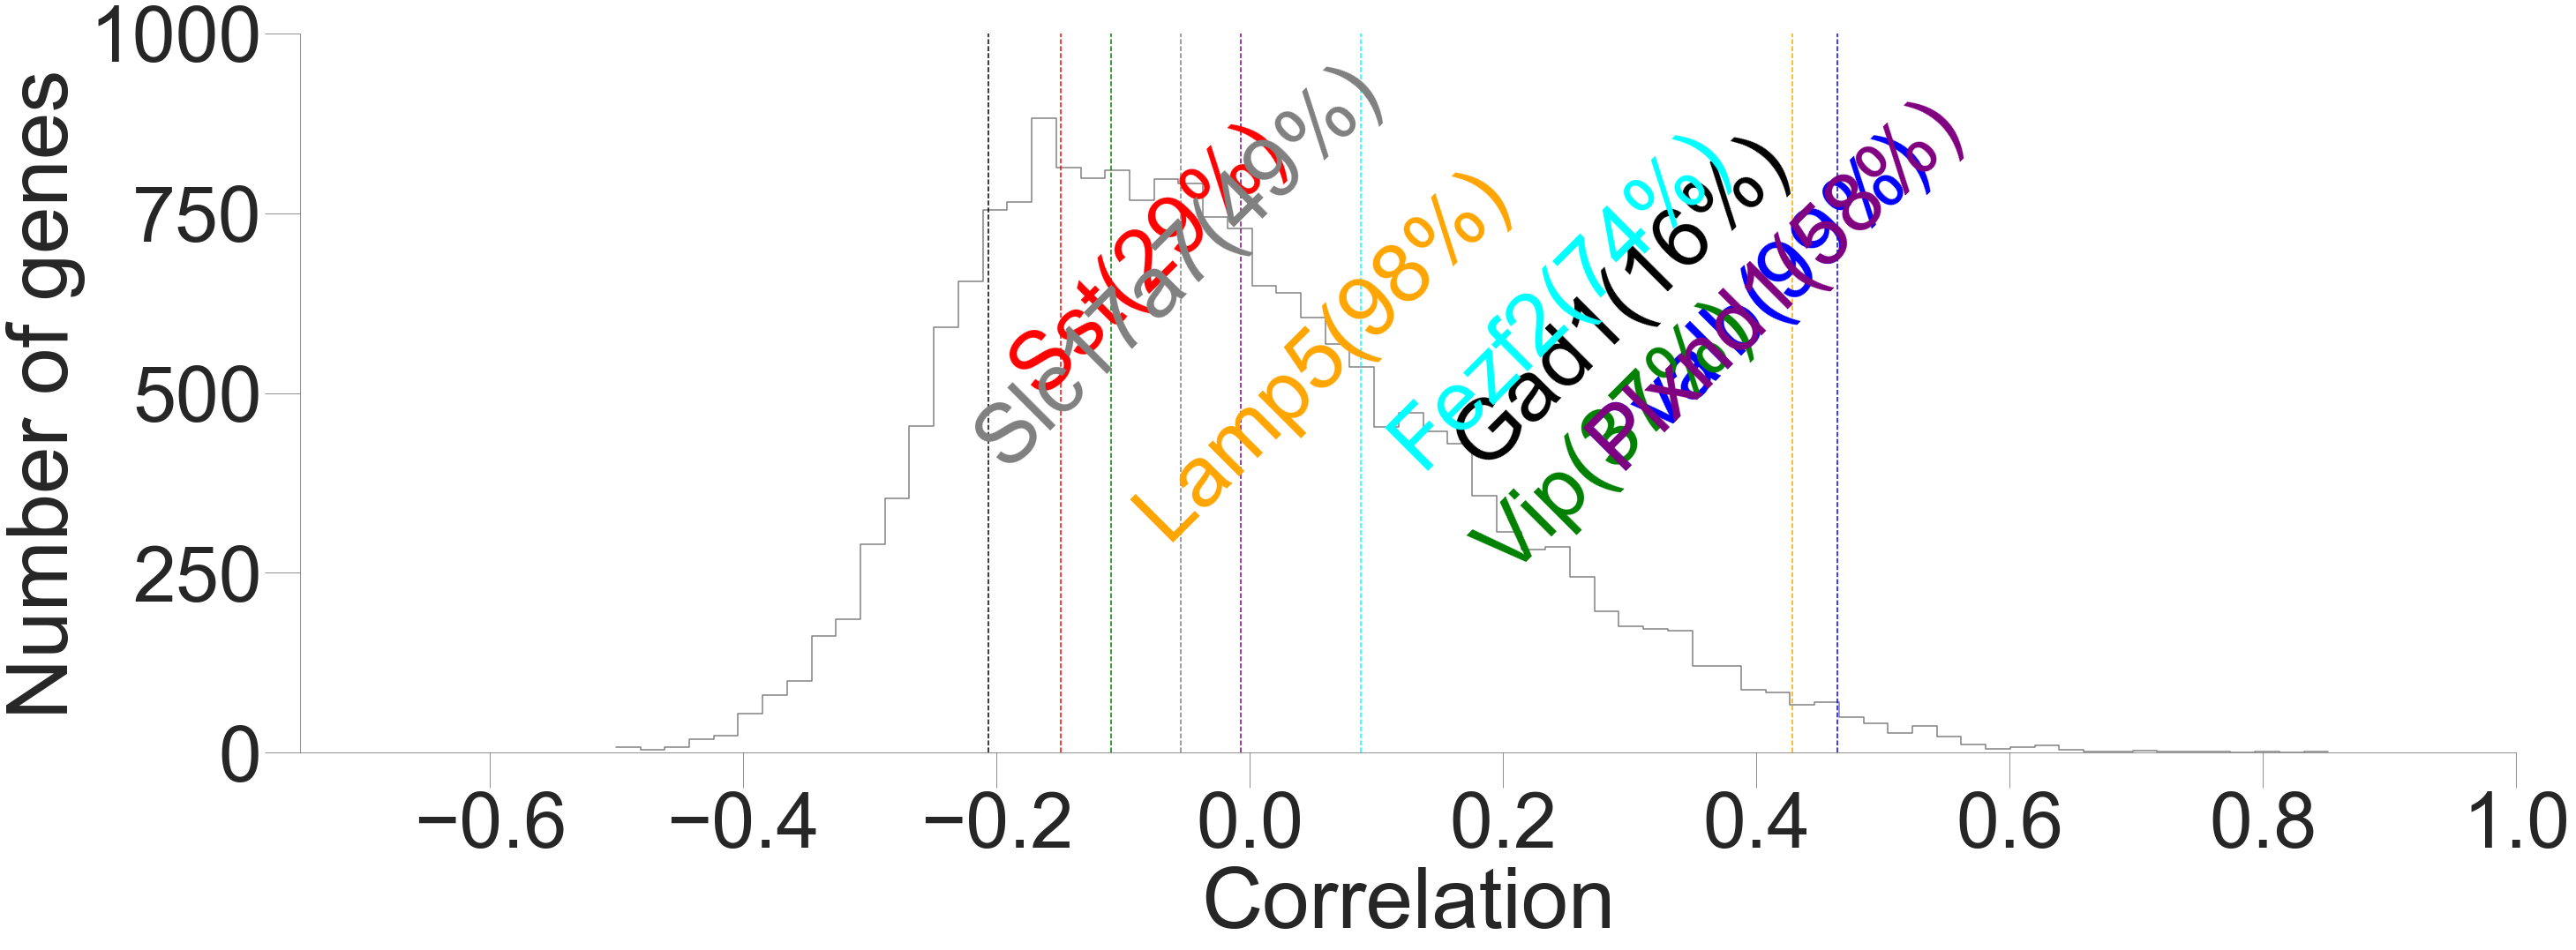

In [41]:
#plot main figure for all genes
plt.figure(figsize=(45,15))
sns.set(style="ticks", font_scale=8)

ax = sns.histplot(data=ket_ctx_cell_type_correlations, x="correlation", element = 'step', fill=False, color='grey')
sns.despine()

trans = ax.get_xaxis_transform()

#pvalb
plt.axvline(x=0.464194771, color='blue', linestyle='--')
plt.text(0.257424, .4, 'Pvalb(99%)', transform=trans, color='blue', rotation=45)

#sst
plt.axvline(x=-0.14908805, color='red', linestyle='--')
plt.text(-0.2, .5, 'Sst(29%)', transform=trans, color='red', rotation=45)

#vip
plt.axvline(x=-0.109343516, color='green', linestyle='--', lw=1.5)
plt.text(0.169885, .25, 'Vip(37%)', transform=trans, color='green', rotation=45)

#lamp5
plt.axvline(x=0.428151425, color='orange', linestyle='--', lw=1.5)
plt.text(-0.10, .3, 'Lamp5(98%)', transform=trans, color='orange', rotation=45)

#slc17a7
plt.axvline(x=-0.05486388, color='grey', linestyle='--', lw=1.5)
plt.text(-0.227017, .4, 'Slc17a7(49%)', transform=trans, color='grey', rotation=45)

#plxnd1
plt.axvline(x=-0.007005171, color='purple', linestyle='--', lw=1.5)
plt.text(0.257424, .4, 'Plxnd1(58%)', transform=trans, color='purple', rotation=45)

#Gad1
plt.axvline(x=-0.206457719, color='black', linestyle='--', lw=1.5)
plt.text(0.15, .4, 'Gad1(16%)', transform=trans, color='black', rotation=45)

#Fezf2
plt.axvline(x=0.087312102, color='cyan', linestyle='--', lw=1.5)
plt.text(0.1, .4, 'Fezf2(74%)', transform=trans, color='cyan', rotation=45)

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlabel('Correlation')
plt.ylabel('Number of genes')
plt.xlim(-0.75,1.0)
plt.ylim(0,1000)